In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
%matplotlib inline  

## read data

In [3]:
df = pd.read_csv('sample_searches.csv')
print 'Data shape - {}'.format(df.shape)
df.head()

Data shape - (25200, 16)


,portal_id,searched_date,origin,destination,departure_date,return_date,number_of_adults,number_of_children,number_of_seniors,flight_class,cheapest_total_fare,cheapest_engine,unique_airlines,country_code,region,city
0,92,2017-01-06,ZYR,BUD,2017-03-23,2017-03-25,1,0,0,1,271.799988,9,AF*KL KL*AF AF*SN KL*SN AF*LH KL*LH AF*AZ,-,-,-
1,92,2017-01-06,ZYL,DAC,2017-01-25,NaN,1,0,0,1,106.809998,9,BG,US,NEW JERSEY,WOODBRIDGE
2,200,2017-01-06,ZWS,NYC,2017-01-22,2017-05-30,1,0,0,1,523.660000,9,LH AB,-,-,-
3,92,2017-01-06,ZWI,SAV,2017-01-10,2017-01-19,1,0,0,1,372.899994,1,UA UA*AA,-,-,-
4,92,2017-01-06,ZWE,NYC,2017-03-26,2017-04-04,1,0,0,1,546.059998,1,KL*AF,NL,ZUID-HOLLAND,DORDRECHT


# Check number of unique values for each feature

In [4]:
df.nunique()

portal_id                 10
searched_date             14
origin                  2166
destination             1587
departure_date           341
return_date              342
number_of_adults           1
number_of_children         1
number_of_seniors          1
flight_class               4
cheapest_total_fare    20898
cheapest_engine           17
unique_airlines        16131
country_code             152
region                   331
city                    1228
dtype: int64

# There is only one unique combination for number of passengers: 1 adult, 0 children, 0 seniors. 
## So we can drop these columns

In [5]:
df = df.drop(['number_of_adults','number_of_children','number_of_seniors'], axis = 1)

# Check missing values

In [6]:
df.isnull().sum() / df.shape[0]

portal_id              0.000000
searched_date          0.000000
origin                 0.000000
destination            0.000000
departure_date         0.000000
return_date            0.404008
flight_class           0.000000
cheapest_total_fare    0.000000
cheapest_engine        0.000000
unique_airlines        0.000000
country_code           0.000079
region                 0.000000
city                   0.000000
dtype: float64

## Here we can see that almost all blanks are return dates
## The reason for this is that if returned_date specified - it will be round trip otherwise one-way trip
## Create new feature - round_trip, delete return_date

In [7]:
df['round_trip'] = df.return_date.notnull()
df = df.drop('return_date', axis = 1)

## Looks like data were filtered to 1800 samples each day.

In [8]:
print df.searched_date.value_counts()

2017-01-08    1800
2017-01-09    1800
2017-01-02    1800
2017-01-03    1800
2017-01-01    1800
2017-01-06    1800
2017-01-07    1800
2017-01-04    1800
2017-01-05    1800
2017-01-11    1800
2017-01-10    1800
2017-01-13    1800
2017-01-12    1800
2017-01-14    1800
Name: searched_date, dtype: int64


## There is no price volatility in context of searched day. Looks like searched day (as simple feature) cannot help us to separate samples

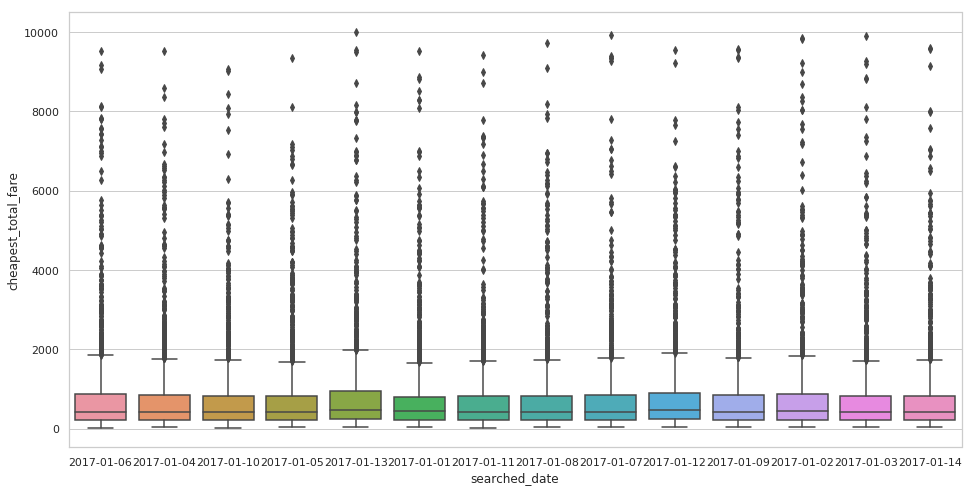

In [9]:
plt.figure(figsize = (16,8))
sns.boxplot(data = df, x = 'searched_date', y = 'cheapest_total_fare')

## Usually ticket price depends on preliminary purchase period : the earlier the purchase date  - the cheaper the ticket.  So we can discriminate early birds.
## Generate feature period = departure_date - search_date

In [10]:
df['departure_date'] = pd.to_datetime(df.departure_date, format='%Y-%m-%d')
df['searched_date'] = pd.to_datetime(df.searched_date, format='%Y-%m-%d')
df['period'] = (df.departure_date - df.searched_date).dt.days
df = df.drop(['departure_date','searched_date'], axis = 1)

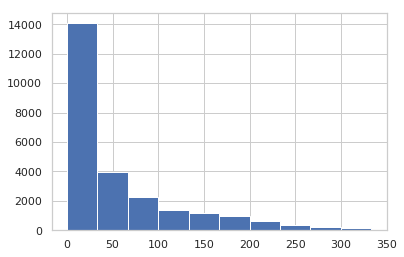

In [11]:
df.period.hist()

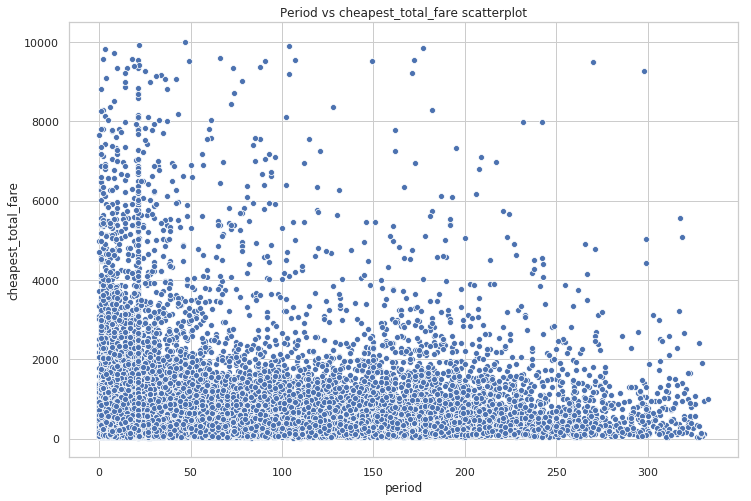

In [12]:
plt.figure(figsize = (12,8))
plt.title('Period vs cheapest_total_fare scatterplot')
sns.scatterplot(x = 'period',y = 'cheapest_total_fare', data = df)

## Explore flight_class

1    24775
2      311
5       64
3       50
Name: flight_class, dtype: int64


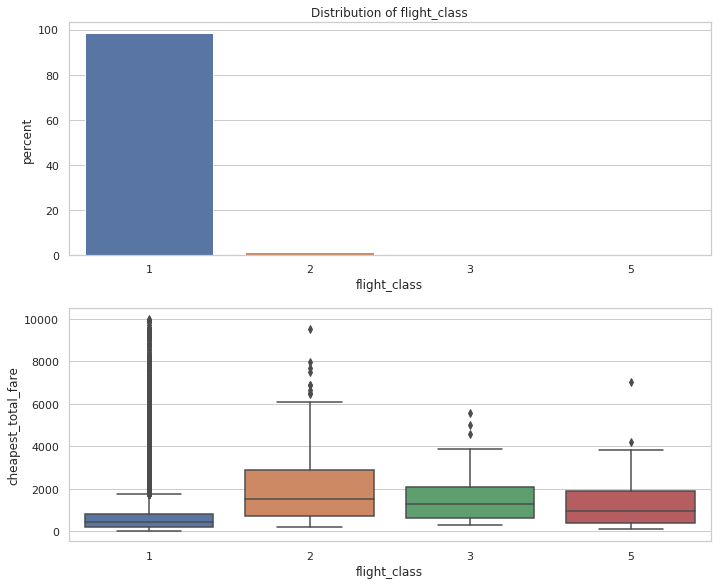

In [13]:
print df.flight_class.value_counts()
fig,ax = plt.subplots(2,1,figsize = (10,8))
ax[0].set_title('Distribution of flight_class')
sns.barplot(x = 'flight_class', y = 'flight_class', data = df, estimator =  lambda i: len(i) / float(len(df)) * 100, ax = ax[0])
ax[0].set(ylabel = 'percent')
plt.tight_layout()
ax[1].set_title('')
sns.boxplot(data = df, x = 'flight_class', y = 'cheapest_total_fare',ax = ax[1] )

## due to small amount of searches with flight class 5 or 3 and significant difference in fare with others - union it in one group. Flight class 2 is  the most expensive, so we remap i to 1 and vice versa.

In [14]:
df.flight_class = df.flight_class.map({1:1,2:2,3:3,5:3})

# Explore portal_id

92     10172
95      9952
93      2145
200     1040
91       837
115      483
201      417
204       72
85        68
96        14
Name: portal_id, dtype: int64


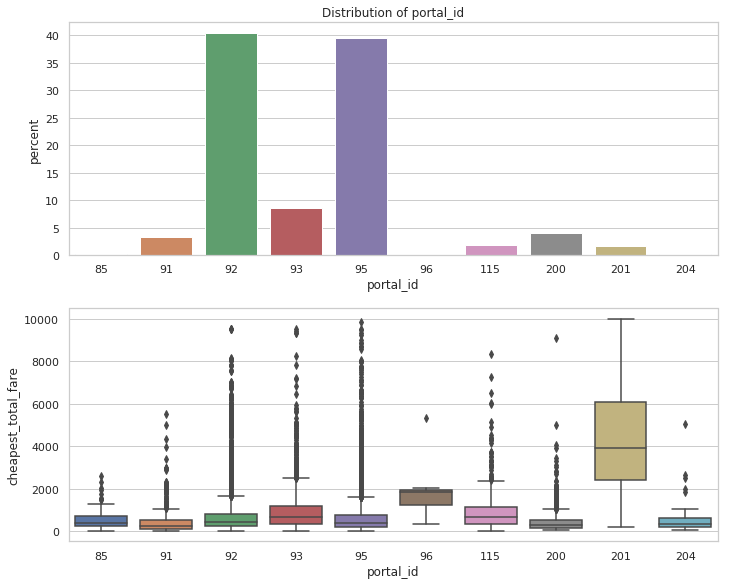

In [15]:
print df.portal_id.value_counts()
fig,ax = plt.subplots(2,1,figsize = (10,8))
ax[0].set_title('Distribution of portal_id')
sns.barplot(x = 'portal_id', y = 'portal_id', data = df, estimator =  lambda i: len(i) / float(len(df)) * 100, ax = ax[0])
ax[0].set(ylabel = 'percent')
plt.tight_layout()
ax[1].set_title('')
sns.boxplot(data = df, x = 'portal_id', y = 'cheapest_total_fare',ax = ax[1] )

## union portal_ids with too few occurences into one portal_id

In [16]:
df.portal_id = df.portal_id.map({92:92,95:95,93:93,200:200,91:91,115:115,201:201,204:0,85:0,96:0})

## Explore cheapest_engine

9      12517
1      10363
10       872
19       813
29       222
14       111
104       58
6         53
22        49
23        38
2         32
99        25
100       22
26        12
105       10
20         2
25         1
Name: cheapest_engine, dtype: int64


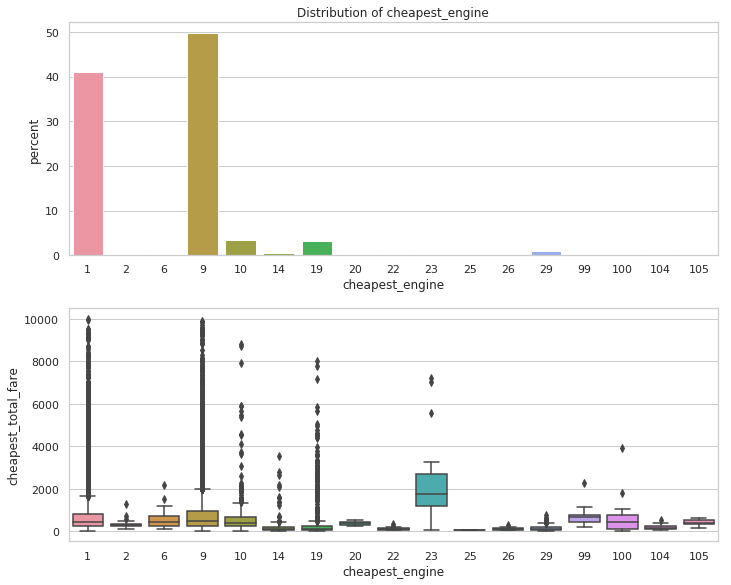

In [17]:
print df.cheapest_engine.value_counts()
fig,ax = plt.subplots(2,1,figsize = (10,8))
ax[0].set_title('Distribution of cheapest_engine')
sns.barplot(x = 'cheapest_engine', y = 'cheapest_engine', data = df, estimator =  lambda i: len(i) / float(len(df)) * 100, ax = ax[0])
ax[0].set(ylabel = 'percent')
plt.tight_layout()
ax[1].set_title('')
sns.boxplot(data = df, x = 'cheapest_engine', y = 'cheapest_total_fare',ax = ax[1] )

## union cheapes_engines with too few occurences into one group

In [18]:
remain = [9,1,10,19]
df.cheapest_engine = df.cheapest_engine.apply(lambda x: x if x in remain else 0)

## geo features
## I have found IATA codes of airports with some additional informational about airport(https://datahub.io/core/airport-codes#python) e.g:
## 1. Continent
## 2. Country
## 3. latitude
## 4.longitude
## Retrieve this data for origin and destination and create new features:
## a) International flight
## b) Intercontinental flight
## c) Flight distance
## d) Origin_country, origin_continent
## e) Destination_country, Destination_continent

## drop initial features

## !!NOTE : not all IATA codes(origin,destination) exist in external data source but almost all raws can be merged succesfully ( about 90% of data). For sake of simplicity just dropped rows with unknown codes

In [19]:
def get_distance(row):
    R = 6373.0

    lat1 = row['origin_latitude_deg']
    lon1 = row['origin_longitude_deg']
    lat2 = row['destination_latitude_deg']
    lon2 = row['destination_longitude_deg']

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    return R * c

In [20]:
airports = pd.read_csv('airports.csv')
remain = ['continent','iso_country','iata_code','longitude_deg','latitude_deg']
airports = airports[remain]
airports = airports.dropna(subset=['iata_code']).drop_duplicates("iata_code")
airports.continent = airports.continent.fillna('NA')

print "airports data shape - {}".format(airports.shape)


origin_columns = ['origin_' + x for x in remain ]
airports.columns = origin_columns
df = df.merge(airports,how='left',left_on='origin',right_on = 'origin_iata_code')

destination_columns = ['destination_' + x for x in remain]
airports.columns = destination_columns
df = df.merge(airports,how='left',left_on='destination',right_on = 'destination_iata_code')


df = df.dropna(subset=['origin_iata_code','destination_iata_code'])
print "final shape - {}".format(df.shape)

airports data shape - (9022, 5)
final shape - (21857, 22)


In [21]:
df['international_flight'] = df.origin_iso_country != df.destination_iso_country
df['intercontinental_flight'] = df.origin_continent != df.destination_continent
df['flight_distance'] = df.apply(lambda x: get_distance(x), axis = 1)

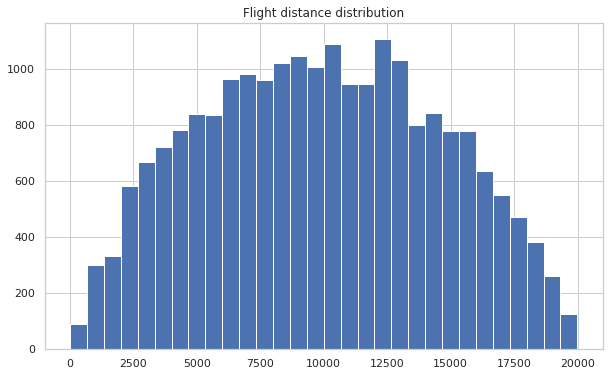

In [22]:
plt.figure(figsize = (10,6))
plt.title("Flight distance distribution")
df.flight_distance.hist(bins = 30)

In [23]:
df = df.drop(['origin','destination','origin_iata_code','origin_longitude_deg',
         'origin_latitude_deg','destination_iata_code','destination_longitude_deg',
        'destination_latitude_deg',"destination_iso_country",'origin_iso_country'],axis = 1)
df = df.reset_index(drop = True)
df.shape

(21857, 15)

## explore airlines:
## transform to - airlines combination number which carries out the flight

In [24]:
df['airlines_combination'] = df.unique_airlines.apply(lambda x: len(x.split("  ")))
df = df.drop('unique_airlines',axis = 1)

## Explore country_code
## in ~50% of sample this data not specified, otherwise it is US almost evry time. Regroup into 3 types: not_specified, US, others.

In [25]:
df.country_code.value_counts()[:10] / df.shape[0]

-     0.492154
US    0.386009
BE    0.027360
CA    0.014778
UK    0.008967
FR    0.004438
AU    0.003797
PH    0.003706
IN    0.003294
CN    0.002974
Name: country_code, dtype: float64

In [26]:
def regroup(r):
    if r == '- ':
        return 0
    elif r == 'US':
        return 1
    else:
        return 2
df.country_code = df.country_code.apply(lambda x: regroup(x))

## Explore city
## same as country : leave only big groups, create additional - others

In [27]:
df.city.value_counts()[:10]/ df.shape[0]

-                0.592854
CONCORD          0.140001
WOODBRIDGE       0.078007
WILMINGTON       0.038386
MOUNTAIN VIEW    0.009699
MT. LAUREL       0.004484
PARIS            0.003614
OTTAWA           0.003431
SHENZHEN         0.002608
LIVINGSTON       0.002150
Name: city, dtype: float64

In [28]:
def regroup(r):
    if r == '-':
        return 0
    elif r == 'CONCORD':
        return 1
    elif r == 'WOODBRIDGE':
        return 2
    elif r == 'WILMINGTON':
        return 3
    else:
        return 4
df.city = df.city.apply(lambda x: regroup(x))

## Region

In [29]:
df.region.value_counts()[:10] / df.shape[0]

-                0.592854
MASSACHUSETTS    0.141511
NEW JERSEY       0.086563
DELAWARE         0.039072
CALIFORNIA       0.017660
ONTARIO          0.007595
TEXAS            0.005307
FLORIDA          0.004392
NEW YORK         0.004118
ILE-DE-FRANCE    0.003614
Name: region, dtype: float64

In [30]:
def regroup(r):
    if r == '-':
        return 0
    elif r == 'MASSACHUSETTS':
        return 1
    elif r == 'NEW JERSEY':
        return 2
    elif r == 'CALIFORNIA':
        return 3
    else:
        return 4
df.region = df.region.apply(lambda x: regroup(x))

# There many categorical features in final dataframe, since these features do not imply order (flight_class is an exception, but we will not treat it as ordered). In order to use some clustering algorithm we will use one hot encoding to encode it. Also transform numerical features to z scores

In [32]:
from sklearn.preprocessing import StandardScaler
num_cols = ['cheapest_total_fare','period','flight_distance', 'airlines_combination']
cat_cols = [col for col in df.columns if not col in num_cols ]

num = StandardScaler().fit_transform(df[num_cols])
df = pd.get_dummies(df, columns = cat_cols)
df[num_cols] = num

## As we have mixed dataset (numerical/categorical features) we will use k-prototypes procedure in order to make clusters. Module kmodes, implementaton based on this paper:
##  "Extensions to the k-Means Algorithm for Clustering Large Data Sets with Categorical Values"
## link - http://www.cs.ust.hk/~qyang/Teaching/537/Papers/huang98extensions.pdf

## main point wee should know about k prototypes:
## use different dissimilarty metrics for numerical features(default euclidean), matching metric for categorical  and incorporates it.

In [33]:
from kmodes.kprototypes import KPrototypes

## Pick number of clusters by elbow rule

In [41]:
def check_cluster(n_clusters, max_iter = 5, n_init = 1):
    kp = KPrototypes(n_clusters= n_clusters, verbose = 0, max_iter = max_iter, n_init = n_init)
    kp.fit(df, categorical = range(4,df.shape[1]))
    print n_clusters
    return kp.cost_

In [42]:
costs = [check_cluster(i) for i in range(1,30)]

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


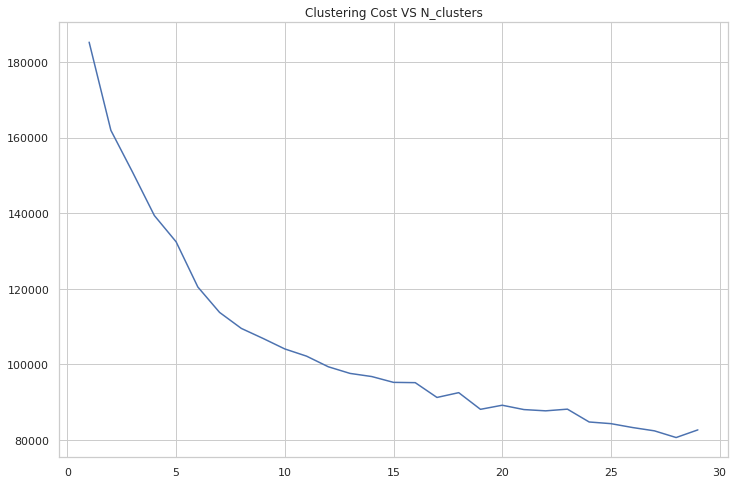

In [43]:
plt.figure(figsize = (12,8))
plt.title("Clustering Cost VS N_clusters")
plt.plot(range(1,30),costs)

## Looks like 6 is suitable number 

In [ ]:
kp = KPrototypes(n_clusters= 6, verbose = 1, max_iter = 20, n_init = 5)
kp.fit(df, categorical = range(4,df.shape[1]))

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/20, moves: 6811, ncost: 120531.274861
Run: 1, iteration: 2/20, moves: 1833, ncost: 119847.818019
Run: 1, iteration: 3/20, moves: 673, ncost: 119678.820465
Run: 1, iteration: 4/20, moves: 360, ncost: 119611.627048
Run: 1, iteration: 5/20, moves: 232, ncost: 119598.400267
Run: 1, iteration: 6/20, moves: 157, ncost: 119593.526122
Run: 1, iteration: 7/20, moves: 110, ncost: 119591.172778
Run: 1, iteration: 8/20, moves: 51, ncost: 119590.373018
Run: 1, iteration: 9/20, moves: 37, ncost: 119589.748504
Run: 1, iteration: 10/20, moves: 57, ncost: 119589.034738
Run: 1, iteration: 11/20, moves: 39, ncost: 119588.625486
Run: 1, iteration: 12/20, moves: 40, ncost: 119588.139567
Run: 1, iteration: 13/20, moves: 29, ncost: 119587.866133
Run: 1, iteration: 14/20, moves: 18, ncost: 119587.802616
Run: 1, iteration: 15/20, moves: 7, ncost: 119587.785365
Run: 1, iteration: 16/20, moves: 9, ncost: 119587.7